## 1.EXPLORING DATA

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#Let's assign the directories...
train_dir="../input/vegetable-image-dataset/Vegetable Images/train/"
test_dir="../input/vegetable-image-dataset/Vegetable Images/test"

In [3]:
# Let's get the class names
import pathlib
import numpy as np
data_dir = pathlib.Path(train_dir)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))
print(class_names)

['Bean' 'Bitter_Gourd' 'Bottle_Gourd' 'Brinjal' 'Broccoli' 'Cabbage'
 'Capsicum' 'Carrot' 'Cauliflower' 'Cucumber' 'Papaya' 'Potato' 'Pumpkin'
 'Radish' 'Tomato']


## 2.Viewing Random Images

In [4]:
#Let's make a function to view a random image from a particular class
def view_random_image(target_dir, target_class):
  # Setup the target directory (we'll view images from here)
  target_folder = target_dir+target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)
  print(random_image)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

In [5]:
#common libraries to import
import random
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from keras import layers,mixed_precision
from shutil import copyfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

['0957.jpg']
Image shape: (224, 224, 3)


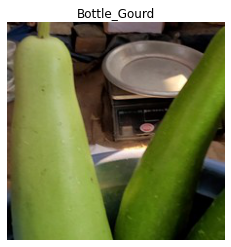

In [6]:
#Let's visualize some images
import random
img = view_random_image(target_dir=train_dir,
                        target_class=random.choice(class_names))

## 3.Dividing into batches

In [7]:
#Let's divide the data into batches
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Rescale
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

# Load data in from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(224, 224),
                                               batch_size=32,
                                               class_mode="categorical")

test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(224, 224),
                                             batch_size=32,
                                             class_mode="categorical")

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


## 4.Creating a Baseline model

In [8]:
# How about we try and simplify the model first
import keras
from keras.models import Sequential
from keras.layers import Conv2D,Dense,MaxPool2D,Flatten,Dropout
model = Sequential([
  Conv2D(10, 3, activation="relu", input_shape=(224, 224, 3)),
  MaxPool2D(),
  Conv2D(10, 3, activation="relu"),
  MaxPool2D(),
  Flatten(),
  Dense(15, activation="softmax")
])

model.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

2022-05-11 18:08:42.474558: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 18:08:42.615293: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 18:08:42.616258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-11 18:08:42.618441: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

## 5.Fitting our model

In [9]:
#Let's fit our first model
history = model.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=len(test_data))

2022-05-11 18:08:45.659209: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2022-05-11 18:08:47.159690: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


469/469 [==============================] - 161s 328ms/step - loss: 1.2063 - accuracy: 0.6243 - val_loss: 0.7386 - val_accuracy: 0.7583
Epoch 2/5
469/469 [==============================] - 44s 94ms/step - loss: 0.4745 - accuracy: 0.8568 - val_loss: 0.5293 - val_accuracy: 0.8413
Epoch 3/5
469/469 [==============================] - 44s 94ms/step - loss: 0.2573 - accuracy: 0.9230 - val_loss: 0.4950 - val_accuracy: 0.8557
Epoch 4/5
469/469 [==============================] - 45s 96ms/step - loss: 0.1471 - accuracy: 0.9581 - val_loss: 0.4908 - val_accuracy: 0.8563
Epoch 5/5
469/469 [==============================] - 45s 95ms/step - loss: 0.0987 - accuracy: 0.9729 - val_loss: 0.6392 - val_accuracy: 0.8417


## 6.Predicting custom images

In [10]:
#predicting custom image
# Create a function to import and image and resize it to be able to be used with our model
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor and reshapes it 
  to (img_shape, img_shape, colour_channels).
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, size=[img_shape, img_shape])
  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

In [12]:
# Configuring pred_and_plot function to work with multi-class images
def pred_and_plot(model, filename, class_names=class_names):
  """
  Imports an image located at filename, makes a prediction with model
  and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Add in logic for multi-class & get pred_class name
  if len(pred[0]) > 1:
    pred_class = class_names[tf.argmax(pred[0])]
  else:
    pred_class = class_names[int(tf.round(pred[0]))]

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

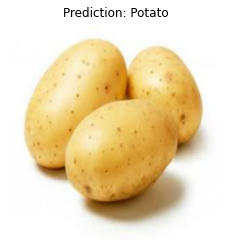

In [13]:
#Let's predict some custom downloaded images from google
pred_and_plot(model=model,
              filename="../input/custom/potato.jpg",
              class_names=class_names)

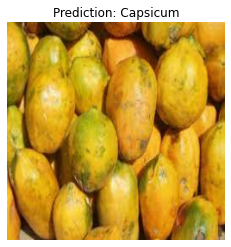

In [14]:
pred_and_plot(model=model,
              filename="../input/papaya2/pap2.jpg",
              class_names=class_names)

## 7.Improving our model through TRANSFER LEARNING

In [15]:
# As we can observe our prediction got wrong..we will try with transfer learning
inception_url="https://tfhub.dev/google/imagenet/inception_v3/feature_vector/5"
# Import dependencies 
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [16]:
#Declaring some of the parameters to reuse efficiently instead of defining every time
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32
IMAGE_SHAPE + (3,)

(224, 224, 3)

In [17]:
# Let's make a create_model() function to create a model from a URL
def create_model(model_url, num_classes=15):
  """
  Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output layer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name="feature_extraction_lyaer",
                                           input_shape=IMAGE_SHAPE+(3,)) 

  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])
    
  return model  

In [18]:
# Create Inception model 
inception_model = create_model(inception_url,
                            num_classes=15)

In [19]:
# Compile our Inception model
inception_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [20]:
# Let's fit our Inception model to the data (10 percent of 10 classes)
history = inception_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  )

Epoch 1/5
469/469 [==============================] - 55s 108ms/step - loss: 0.1839 - accuracy: 0.9526 - val_loss: 0.0598 - val_accuracy: 0.9880
Epoch 2/5
469/469 [==============================] - 48s 103ms/step - loss: 0.0312 - accuracy: 0.9939 - val_loss: 0.0371 - val_accuracy: 0.9887
Epoch 3/5
469/469 [==============================] - 49s 105ms/step - loss: 0.0161 - accuracy: 0.9974 - val_loss: 0.0272 - val_accuracy: 0.9923
Epoch 4/5
469/469 [==============================] - 50s 106ms/step - loss: 0.0093 - accuracy: 0.9993 - val_loss: 0.0250 - val_accuracy: 0.9933
Epoch 5/5
469/469 [==============================] - 52s 110ms/step - loss: 0.0067 - accuracy: 0.9993 - val_loss: 0.0217 - val_accuracy: 0.9943


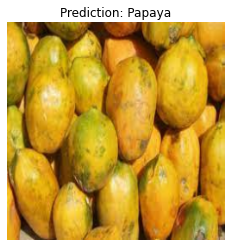

In [21]:
pred_and_plot(model=inception_model,
              filename="../input/papaya2/pap2.jpg",
              class_names=class_names)

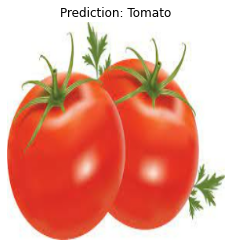

In [22]:
pred_and_plot(model=inception_model,
              filename="../input/custom/tomato.jpg",
              class_names=class_names)

In [ ]:
#boom we got our prediction right so let's try another transfer learning model to improve accuracy(as human is always greedy)

In [25]:
eff_url="https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1"
eff_model = create_model(eff_url,
                            num_classes=15)

In [26]:
# Compile our Efficient model
eff_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [27]:
# let's fit our Efficient model
eff_history = eff_model.fit(train_data,
                                  epochs=5,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  )

Epoch 1/5
469/469 [==============================] - 151s 269ms/step - loss: 0.2184 - accuracy: 0.9619 - val_loss: 0.0553 - val_accuracy: 0.9887
Epoch 2/5
469/469 [==============================] - 122s 260ms/step - loss: 0.0366 - accuracy: 0.9950 - val_loss: 0.0280 - val_accuracy: 0.9947
Epoch 3/5
469/469 [==============================] - 122s 260ms/step - loss: 0.0198 - accuracy: 0.9979 - val_loss: 0.0184 - val_accuracy: 0.9963
Epoch 4/5
469/469 [==============================] - 122s 260ms/step - loss: 0.0129 - accuracy: 0.9987 - val_loss: 0.0141 - val_accuracy: 0.9963
Epoch 5/5
469/469 [==============================] - 122s 260ms/step - loss: 0.0091 - accuracy: 0.9989 - val_loss: 0.0130 - val_accuracy: 0.9967


## 8.Evaluating model with loss curves

In [28]:
# Let's create a function to plot our loss curves...
import matplotlib.pyplot as plt

# Plot the validation and training curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow History object.

  Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="val_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

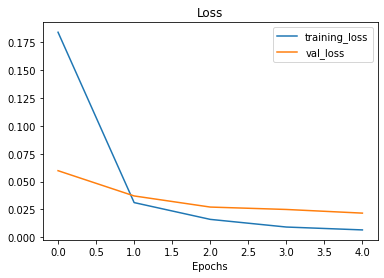

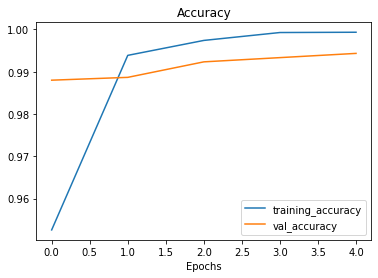

In [29]:
plot_loss_curves(history)

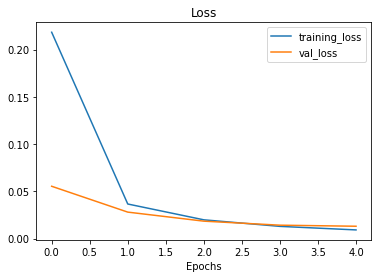

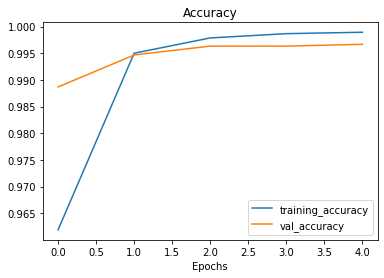

In [30]:
plot_loss_curves(eff_history)